# 0. Imports

In [136]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid');
matplotlib.style.use('ggplot');
import string

%matplotlib inline
%config Completer.use_jedi = False


# 1. Data loading

In [137]:
df_data_raw = pd.read_csv("data/elo7_recruitment_dataset.csv")
df_data_raw.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


# 2. EDA

In [138]:
data = df_data_raw.copy()

In [139]:
# Join the different processed titles together.
long_string = ','.join(list(data['query'].values))

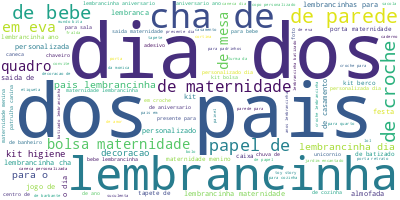

In [140]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [141]:
stop_words = []


with open('data/stopwords_portuguese', 'r') as reader:
    stop_words = [line.strip() for line in reader]


stop_words.extend(['dia'])

In [142]:
def text_preprocess(text):
    """
    1. remove pontuação
    2. remove stop words
    3. retorna lista de palavras resultante
    """
    
    sem_pontuacao = [char for char in text if char not in string.punctuation]    
    sem_pontuacao = ''.join(sem_pontuacao)    
    sem_stop_words = [word for word in sem_pontuacao.split() if word.lower() not in stop_words]
    
    return sem_stop_words

In [143]:
import gensim
from gensim.utils import simple_preprocess

In [144]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [145]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [146]:
data = data['query'].values.tolist()
data_words = list(sent_to_words(data))

In [147]:
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['espirito', 'santo']


In [148]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
# Create Dictionary
id2word = corpora.Dictionary(data_words)

In [149]:
# Create Corpus
texts = data_words

In [150]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [151]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [152]:
from tqdm import tqdm

In [153]:
limit=20; start=1; step=2;

# Colocando parametros na função
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Mostrando visualmente a quantidade de tópicos
print(coherence_values)





100%|██████████| 10/10 [00:36<00:00,  3.68s/it]

[0.6313152282926794, 0.6248345230108768, 0.6166378501483079, 0.6135673215636299, 0.6004500608652731, 0.6010739203698379, 0.6023208644928777, 0.6129263957398692, 0.6105762106140911, 0.595166777101295]


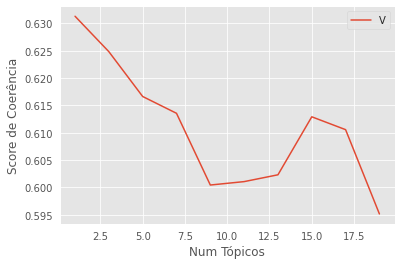

A quantidade de tópicos = 1  tem um valor de coerência de  0.6313
A quantidade de tópicos = 3  tem um valor de coerência de  0.6248
A quantidade de tópicos = 5  tem um valor de coerência de  0.6166
A quantidade de tópicos = 7  tem um valor de coerência de  0.6136
A quantidade de tópicos = 9  tem um valor de coerência de  0.6005
A quantidade de tópicos = 11  tem um valor de coerência de  0.6011
A quantidade de tópicos = 13  tem um valor de coerência de  0.6023
A quantidade de tópicos = 15  tem um valor de coerência de  0.6129
A quantidade de tópicos = 17  tem um valor de coerência de  0.6106
A quantidade de tópicos = 19  tem um valor de coerência de  0.5952


In [154]:

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

In [164]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)




# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)

[(0,
  '0.080*"pais" + 0.040*"lembrancinha" + 0.040*"personalizado" + '
  '0.027*"lembrancinhas" + 0.026*"papel" + 0.021*"parede" + 0.020*"porta" + '
  '0.017*"kit" + 0.016*"eva" + 0.012*"decoracao"'),
 (1,
  '0.042*"maternidade" + 0.035*"bebe" + 0.024*"tapete" + 0.023*"lembrancinhas" '
  '+ 0.022*"personalizada" + 0.022*"croche" + 0.019*"pais" + 0.016*"decoracao" '
  '+ 0.016*"cha" + 0.015*"porta"'),
 (2,
  '0.042*"lembrancinha" + 0.041*"festa" + 0.035*"lembrancinhas" + '
  '0.029*"batizado" + 0.027*"anos" + 0.027*"kit" + 0.023*"maternidade" + '
  '0.021*"presente" + 0.015*"personalizada" + 0.013*"bolsa"'),
 (3,
  '0.113*"lembrancinha" + 0.036*"maternidade" + 0.026*"bebe" + 0.021*"kit" + '
  '0.020*"caixa" + 0.018*"lembranca" + 0.017*"croche" + 0.016*"personalizada" '
  '+ 0.015*"cha" + 0.015*"berco"')]

Score de Coerência:  0.6093360351703553


In [165]:
%mkdir results

mkdir: não foi possível criar o diretório “results”: Arquivo existe


In [166]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.153231  0.018567       1        1  25.870086
1     -0.043462 -0.136971       2        1  25.106337
2      0.001589  0.038843       3        1  24.842222
3     -0.111358  0.079562       4        1  24.181356, topic_info=              Term         Freq        Total Category  logprob  loglift
17    lembrancinha  4416.000000  4416.000000  Default  30.0000  30.0000
13            pais  2786.000000  2786.000000  Default  29.0000  29.0000
24   personalizado  1009.000000  1009.000000  Default  28.0000  28.0000
105          festa  1148.000000  1148.000000  Default  27.0000  27.0000
38        batizado   858.000000   858.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
261           sala   125.906677   315.043180   Topic4  -5.1374   0.5024
13            pais   282.262232  2786.519630   Topic4  -4.3301  -0.8701
48          menina   113.161165   396.572349   Topic4  -5.2441   0.1655
69             mdf    88.350778   345.234433   Topic4  -5.4916   0.0567
45            anos    85.253548   907.590621   Topic4  -5.5273  -0.9456

[334 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1152      2  0.951697    abelha
751       1  0.039734   abridor
751       3  0.913885   abridor
1584      1  0.907585      acao
239       1  0.254755  acrilico
...     ...       ...       ...
702       2  0.046422   vintage
702       3  0.882017   vintage
702       4  0.046422   vintage
624       1  0.930385      voil
1726      4  0.901025      yoga

[742 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])